# Histogram Equalization

In [124]:
%matplotlib inline 

from scipy import ndimage
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import math

Here's the image we'll be equalizing. Notice the lower light near the bottom and the higher light near the top.

(674, 500, 3)


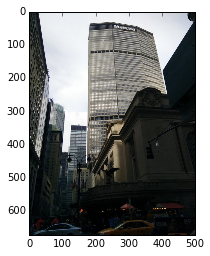

In [125]:
f = ndimage.imread("ny.jpg")
plt.imshow(f)

dims = f.shape
print dims

Here's just the R channel

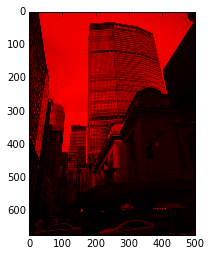

In [126]:
g = np.ndarray.copy(f)
for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
            if(k == 0):
                g[i,j,k] = f[i,j,k]
            else:
                g[i,j,k] = 0
                
plt.imshow(g)

## Standard Histogram Equalization
Let's define the equalization function

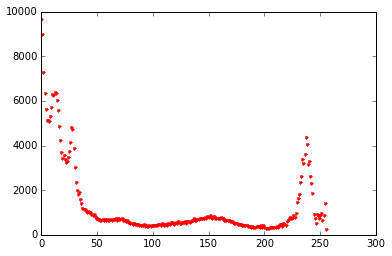

In [127]:
channels = []
for i in range(3):
    channels.append(f[:,:,i])

hist = map(lambda channel: ndimage.measurements.histogram(channel, 0, 255, 256), channels)

plt.plot(hist[0], 'r.')

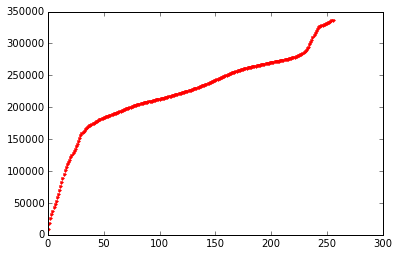

In [128]:
cum = map(lambda h: [], hist)
sums = map(lambda h: 0, hist)
for i in range(256):
    for j in range(3):
        sums[j] += hist[j][i]
        cum[j].append(sums[j])

plt.plot(cum[0], 'r.')      

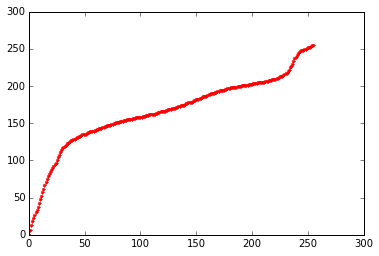

In [129]:
#array must be sorted
def scale(arr, rmin, rmax):
    dmax = float(arr[-1])
    dmin = float(arr[0])
    
    drange = dmax-dmin
    rrange = rmax-rmin
    
    shifted_down = map(lambda x: float(x) - dmin, arr)
    scaled_up = map(lambda f: f * rrange, shifted_down)
    scaled_down = map(lambda f: f / drange, scaled_up)
    shifted_up = map(lambda f: f + rmin, scaled_down)
    ints = map(lambda f: int(round(f)), shifted_up)
    
    return ints

cum = map(lambda cumi: scale(cumi, 0., 255.), cum)
plt.plot(cum[0], 'r.')

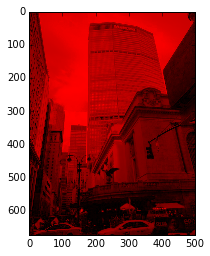

In [130]:
g = np.ndarray.copy(f)
for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
            if(k == 0):
                g[i,j,k] = cum[k][g[i,j,k]]
            else:
                g[i,j,k] = 0

plt.imshow(g)

[9667    0    0    0    0    0    0 8996    0    0    0    0    0 7299    0
    0    0    0 6345    0    0    0 5643    0    0    0 5165    0    0    0
 5161    0    0    0 5100    0    0    0 5321    0    0    0    0 5745    0
    0    0    0 6318    0    0    0 6285    0    0    0    0 6417    0    0
    0    0 6340    0    0    0    0 6034    0    0    0 5585    0    0    0
 4891    0    0    0 4250    0    0 3731    0 3454    0    0 3556    0    0
 3377    0 3262    0    0 3316    0 3502    0    0 3744    0    0    0 4136
    0    0 4819    0    0    0 4756    0    0 3911    0 3040    0 2363    0
 1992 1815    0 1909 1599 1403 1180 1167 1163 2107 1086 1019 1027 1826  926
 1593 1478  694 1329 1343 1396 1352 1410 1384  727 1463 1420 1424 1399 1352
 1313 1162 1055 1489 1435  888 1327 1263 1680  887 1289 1357 1445 1416 1046
 1134 1576 1105 1112 1724 1184 1155 1201 1300 1396 1353  726 1462 1505 1521
  787 1577  814 1662 1556  863 1521 1476  741 1557 1439 1314 1300 1202 1167
 1574  954 1

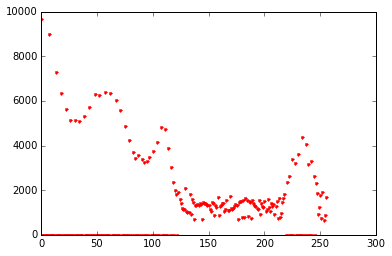

In [131]:
nchannels = []
for i in range(3):
    nchannels.append(g[:,:,i])

nhist = map(lambda channel: ndimage.measurements.histogram(channel, 0, 255, 256), nchannels)

print nhist[0]
plt.plot(nhist[0], 'r.')

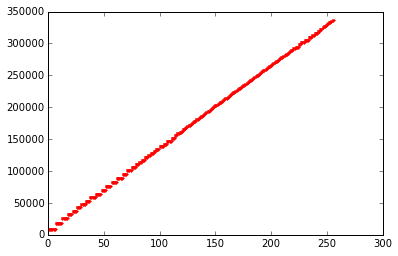

In [133]:
ncum = map(lambda h: [], nhist)
nsums = map(lambda h: 0, nhist)
for i in range(256):
    for j in range(3):
        nsums[j] += nhist[j][i]
        ncum[j].append(nsums[j])

plt.plot(ncum[0], 'r.')        
# ncum = map(lambda cumi: scale(cumi, 0., 255.), ncum)

## Locally Adaptive Histogram Equalization

* wrap histogram generation into function
* call on block sections of image (corner gets 4 blocks)
* use grid of histograms to generate new image

In [13]:
def cum(hists):
    cum = map(lambda h: [], hists)
    sums = map(lambda h: 0, hists)
    for i in range(256):
        for j in range(3):
            sums[j] += hists[j][i]
            cum[j].append(sums[j])

    cum = map(lambda cumi: scale(cumi, 0., 255.), cum)
    return cum

* __hists__ is a set of 3 histograms, one per channel
* __cum__, which is returned, is a set of 3 lookup tables, one per channel

In [35]:
m = 50
histograms = np.empty( (math.ceil(f.shape[0]/m), math.ceil(f.shape[1]/m), 3) )
h_shape = histograms.shape

channels = []
for i in range(3):
    channels.append(f[:,:,i])
    
def w(i, j, k, l):
    s = abs(k-i)/float(m)
    t = abs(l-j)/float(m)
    weight = 1
    
    weight *= (1-s) if k <= i else (s)
    weight *= (1-t) if l <= j else (t)
    

def slice(img, k, l):
    minx = max((k-1)*m, 0)
    miny = max((l-1)*m, 0)
    maxx = min((k+1)*m, img.shape[0])
    maxy = min((l+1)*m, img.shape[1])
    
    s = img[minx:maxx][miny:maxy]
    weights = np.empty(s.shape)
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            weights[i,j] = w(i+minx,j+miny,k,l) #bilinear weighting function
    
    return s, weights

def hist_slice(img, k, l):
    s, weights = slice(img, k, l)
    return np.histogram(s, bins=256, range=(0,255), weights=weights)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [43]:
for i in range(h_shape[0]):
    for j in range(h_shape[1]):
#         print i, j
#         print map(lambda channel: hist_slice(channel, i, j), channels)

IndentationError: expected an indented block (<ipython-input-43-08c4c8f2fc01>, line 4)